In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import seaborn as sns

sns.set_style('darkgrid')

In [104]:
class UniformGravity(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, dt = 1.0, max_t = 200, target_alt = 1.0, thrust_gs= 1.2, g = 1.0,
                 record_history = True, record_rate = 100):
        
        super(UniformGravity, self).__init__()
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([-thrust_gs]), 
                                           high=np.array([thrust_gs]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot)
        self.observation_space = gym.spaces.Box(low=np.array([-10,-10]), 
                                                high=np.array([10,10]), 
                                                dtype=np.float32)
        
        self.record_history = record_history
        
        # setting the target r in natural units
        self.dt = dt
        self.record_rate = record_rate
        self.max_thrust = thrust_gs
        self.max_t = max_t
        self.max_steps = int(max_t/dt)
        self.g = g
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Translational Coordinates
        self.r = np.clip(np.random.normal(0.0,2.5),a_min = -5.0, a_max=5.0)
        self.r_dot = np.clip(np.random.normal(0.0,0.5),a_min = -1.0, a_max=1.0)
        self.r_double_dot = 0.0

        self.episode_steps = 0
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r,self.r_dot]])
        
        obs = np.array([self.r,self.r_dot])
        
        return obs
    
    def step(self, action):
        
        # actions segragation
        thrust = np.clip(action[0]*self.max_thrust, -self.max_thrust, self.max_thrust)

        # Execute one time step within the environment using RK4
        self.episode_steps += 1

        # integrate
        y0_k1 = self.r_dot
        y1_k1 = -self.g + thrust
        
        y0_k2 = (self.r_dot + y1_k1*self.dt/2)
        y1_k2 = -self.g + thrust
         
        y0_k3 = (self.r_dot + y1_k2*self.dt/2)
        y1_k3 = -self.g + thrust
          
        y0_k4 = (self.r_dot + y1_k3*self.dt)
        y1_k4 = -self.g + thrust

        # Update 
        self.r = self.r + self.dt/6*(y0_k1 + 2*y0_k2 + 2*y0_k3 + y0_k4)
        self.r_dot = self.r_dot + self.dt/6*(y1_k1 + 2*y1_k2 + 2*y1_k3 + y0_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory,[[self.r,self.r_dot]],axis=0)
        
        
        reward = np.exp(-(self.r)**2/(2*(2./3.)**2)) - 0.5*action[0]**2
        
        # set if at the terminal state
        done = False
        
        if self.episode_steps > self.max_steps:
            done = True
        
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1):
        pass

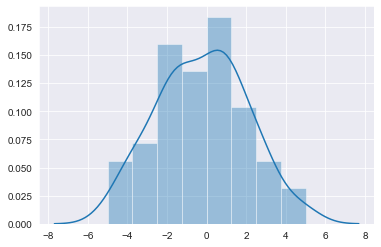

In [103]:
sns.distplot(np.clip(np.random.normal(0.0,2.5,100),a_min = -5.0, a_max=5.0))

In [105]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs]).to(device)
            mu_v = net(obs_v)
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            obs, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count

def unpack_batch_ddqn(batch, device="cpu"):
    states, actions, rewards, dones, last_states = [], [], [], [], []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = ptan.agent.float32_preprocessor(actions).to(device)
    rewards_v = ptan.agent.float32_preprocessor(rewards).to(device)
    last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
    dones_t = torch.LongTensor(dones).to(device)
    return states_v, actions_v, rewards_v, dones_t, last_states_v


HIDDEN_SIZE = 128

class DDPGActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGActor, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, act_size),
            nn.Tanh() # output between [-1,1] and scale it in the environment
        )

    def forward(self, x):
        return self.net(x)


class DDPGCritic(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGCritic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
        )

        self.out_net = nn.Sequential(
            nn.Linear(HIDDEN_SIZE + act_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, a):
        obs = self.obs_net(x)
        return self.out_net(torch.cat([obs, a], dim=1))
    
class AgentDDPG(ptan.agent.BaseAgent):
    """
    Agent implementing Orstein-Uhlenbeck exploration process
    """
    def __init__(self, net, device="cpu", epsilon=1.0):
        self.net = net
        self.device = device
        self.epsilon = epsilon

    def initial_state(self):
        return None

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states).to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()

        if np.random.random() > self.epsilon:
            actions = 2*np.random.random(actions.shape) - 1 
            new_a_states = actions
        else:
            new_a_states = agent_states
            
        return actions, new_a_states

In [106]:
GAMMA = 0.99
TAU = 0.01

BATCH_SIZE = 256
LEARNING_RATE = 1e-4

REPLAY_SIZE = 100000
REPLAY_INITIAL = 10000

TEST_ITERS = 1000

env = UniformGravity(dt = 0.05, max_t = 200, g = 0.0, record_history=False)
test_env = UniformGravity(dt = 0.05, max_t = 200, g = 0.0, record_history=True)

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

act_net = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
crt_net = DDPGCritic(env.observation_space.shape[0], env.action_space.shape[0]).to(device)

tgt_act_net = ptan.agent.TargetNet(act_net)
tgt_crt_net = ptan.agent.TargetNet(crt_net)

agent = AgentDDPG(act_net, device=device, epsilon = 0.5)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count=1)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, buffer_size=REPLAY_SIZE)

act_opt = optim.Adam(act_net.parameters(), lr=LEARNING_RATE)
crt_opt = optim.Adam(crt_net.parameters(), lr=LEARNING_RATE)

In [108]:
frame_idx = 0
best_reward = None

while True:
    frame_idx += 1
    buffer.populate(1)
    #rewards_steps = exp_source.pop_rewards_steps()

    if len(buffer) < REPLAY_INITIAL:
        continue

    batch = buffer.sample(BATCH_SIZE)
    states_v, actions_v, rewards_v, dones_mask, last_states_v = \
        unpack_batch_ddqn(batch, device)

    # train critic
    crt_opt.zero_grad()

    q_v = crt_net(states_v, actions_v)
    last_act_v = tgt_act_net.target_model(last_states_v)

    q_last_v = tgt_crt_net.target_model(last_states_v, last_act_v)
    q_last_v[dones_mask] = 0.0
    q_ref_v = rewards_v.unsqueeze(dim=-1) + q_last_v * GAMMA

    critic_loss_v = F.mse_loss(q_v, q_ref_v.detach())
    critic_loss_v.backward()
    crt_opt.step()

    # train actor
    act_opt.zero_grad()

    cur_actions_v = act_net(states_v)
    actor_loss_v = -crt_net(states_v, cur_actions_v)
    actor_loss_v = actor_loss_v.mean()

    actor_loss_v.backward()
    act_opt.step()

    tgt_act_net.alpha_sync(alpha=1 - TAU)
    tgt_crt_net.alpha_sync(alpha=1 - TAU)

    if frame_idx % TEST_ITERS == 0:
        agent.epsilon = np.max([0.1,agent.epsilon*0.99]) # reduce the exploration term
        ts = time.time()
        rewards, steps = test_net(act_net, test_env, device=device)
        print("Test done in %.2f sec, avg reward %.3f, avg steps %d" % 
              (time.time() - ts, rewards, steps))

        if best_reward is None or best_reward < rewards:
            if best_reward is not None:
                print("Best reward updated: %.3f -> %.3f" % (best_reward, rewards))
            best_reward = rewards
        
        #if best_reward > 500.00:
        #    print('solved.')
        #    break

Test done in 13.40 sec, avg reward -1859.391, avg steps 4001
Test done in 14.72 sec, avg reward -1931.788, avg steps 4001
Test done in 15.46 sec, avg reward -1946.158, avg steps 4001
Test done in 15.16 sec, avg reward -1974.792, avg steps 4001
Test done in 15.20 sec, avg reward -1987.363, avg steps 4001
Test done in 15.20 sec, avg reward -1977.379, avg steps 4001
Test done in 15.69 sec, avg reward -1988.902, avg steps 4001
Test done in 15.54 sec, avg reward -1990.800, avg steps 4001


KeyboardInterrupt: 

In [109]:
many_traj = []
many_a = []

for _ in range(30):
    traj = []
    a_history = []
    
    s = test_env.reset()
    while True:
        traj.append(s)
    
        s_v = torch.FloatTensor([s]).to(device)
        a_v = act_net(s_v)
        a = a_v.data.cpu().numpy()[0]
        a_history.append( np.clip(a*test_env.max_thrust, -test_env.max_thrust, test_env.max_thrust))
    
        s,r,d,_ = test_env.step(a)
        if d:
            break

    many_traj.append(np.array(traj))
    many_a.append(np.array(a_history))

many_traj = np.array(many_traj)
many_a = np.array(many_a)

KeyboardInterrupt: 

In [86]:
many_traj

array([[[-3.17054721e+00,  5.99677929e-02],
        [-3.15855043e+00,  1.62967256e-01],
        [-3.13625371e+00,  2.67683377e-01],
        ...,
        [-3.03449552e-01,  1.77973379e-03],
        [-3.03276749e-01,  1.72149992e-03],
        [-3.03109597e-01,  1.66523348e-03]],

       [[-1.20935487e-01, -1.32751938e-01],
        [-1.28927736e-01, -4.51544049e-02],
        [-1.34682583e-01, -6.69768887e-02],
        ...,
        [-2.97924945e-01, -8.09834833e-05],
        [-2.97932810e-01, -7.83723005e-05],
        [-2.97940417e-01, -7.57647155e-05]],

       [[ 1.10264217e+00,  9.38732442e-01],
        [ 1.19051542e+00,  8.52377983e-01],
        [ 1.26975321e+00,  7.64584283e-01],
        ...,
        [-2.94174053e-01, -1.34434220e-03],
        [-2.94304581e-01, -1.30033280e-03],
        [-2.94430840e-01, -1.25784698e-03]],

       ...,

       [[ 1.20767611e+00, -8.09371446e-03],
        [ 1.20086680e+00, -1.10227594e-01],
        [ 1.18384473e+00, -2.14052987e-01],
        ...,
     

In [ ]:
plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_traj[:,0].T, color='r', alpha=0.15);
plt.show();

plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_traj[:,:,1].T, color='r', alpha=0.15);
plt.show()

plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_a[:,:,0].T, color='r', alpha=0.15);
plt.show()